In [1]:
import pandas as pd
import os

In [7]:
!pip3 install grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 26.8 MB/s eta 0:00:00a 0:00:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
INFO: pip is looking at multiple versions of scipy to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.9/37.9 MB 26.4 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 18.0 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.9/20.9 MB 24.3 MB/s eta 0:00:00a 0:00:01
  Created wheel for grad-cam: filename=grad_cam-1.5.5-py3-none-any.whl size=44284 sha256=87be8f586d0d4d2cd0550365d31da1815378772063f9bca9b87e62761cac6f67
  Stored in directory: /Users/nakiyahdhariwala/Library/Caches/pip/wheels/fb/3b/09/2afc520f3d69bc26ae6bd87416759c820a3f7d05c1a077bbf6
Successfully built grad-cam
  Attempting uninstall: numpy
    Found existing installat

In [2]:
# mango_pth = "mango_leaf_dataset/"
# mango_dir = os.listdir(mango_pth)
# print(len(mango_dir))
# print(mango_dir)

In [3]:
# diseased = []
# healthy = []
# for val in range(1, 6):
#     print(val)
#     diseased.append(
#         "https://raw.githubusercontent.com/Nakiyah24/ExplainableAI_Assignments/main/Assignment5/mango_leaf_dataset/disease_000%s"
#         % val
#     )
#     healthy.append(
#         "https://raw.githubusercontent.com/Nakiyah24/ExplainableAI_Assignments/main/Assignment5/mango_leaf_dataset/healthy_000%s"
#         % val
#     )

In [4]:
# pin to a ref if you want reproducibility (commit SHA or "main")
REF = "main"  # or: "a22c17af259dc4d68b5fc421c28ac1cb8a3cc082"

BASE = f"https://raw.githubusercontent.com/Nakiyah24/ExplainableAI_Assignments/{REF}/Assignment5/mango_leaf_dataset"

diseased, healthy = [], []
for i in range(1, 6):  # 0001..0005
    diseased.append(f"{BASE}/disease_{i:04d}.JPG")
    healthy.append(f"{BASE}/healthy_{i:04d}.JPG")

print(diseased)
print(healthy)

['https://raw.githubusercontent.com/Nakiyah24/ExplainableAI_Assignments/main/Assignment5/mango_leaf_dataset/disease_0001.JPG', 'https://raw.githubusercontent.com/Nakiyah24/ExplainableAI_Assignments/main/Assignment5/mango_leaf_dataset/disease_0002.JPG', 'https://raw.githubusercontent.com/Nakiyah24/ExplainableAI_Assignments/main/Assignment5/mango_leaf_dataset/disease_0003.JPG', 'https://raw.githubusercontent.com/Nakiyah24/ExplainableAI_Assignments/main/Assignment5/mango_leaf_dataset/disease_0004.JPG', 'https://raw.githubusercontent.com/Nakiyah24/ExplainableAI_Assignments/main/Assignment5/mango_leaf_dataset/disease_0005.JPG']
['https://raw.githubusercontent.com/Nakiyah24/ExplainableAI_Assignments/main/Assignment5/mango_leaf_dataset/healthy_0001.JPG', 'https://raw.githubusercontent.com/Nakiyah24/ExplainableAI_Assignments/main/Assignment5/mango_leaf_dataset/healthy_0002.JPG', 'https://raw.githubusercontent.com/Nakiyah24/ExplainableAI_Assignments/main/Assignment5/mango_leaf_dataset/healthy_0

In [5]:
import requests
from io import BytesIO
from PIL import Image


def get_img(url):
    r = requests.get(url, timeout=15)
    r.raise_for_status()
    return Image.open(BytesIO(r.content)).convert("RGB")


# try first diseased + healthy
_ = get_img(diseased[0])
_ = get_img(healthy[0])
print("OK: both URLs load")

OK: both URLs load


Top-1 class idx: 988


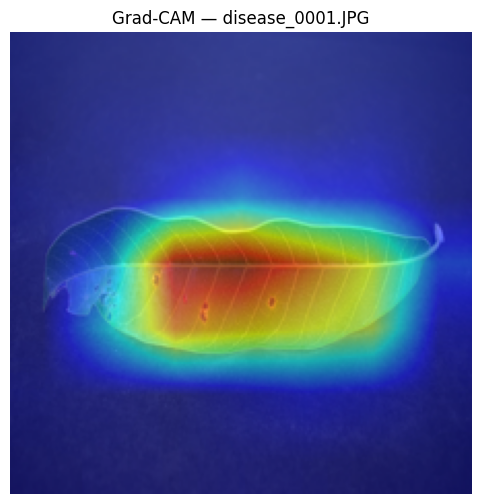

In [9]:
# --- Grad-CAM on one image (fixed API: no `use_cuda`) ---

import torch, numpy as np, requests, matplotlib.pyplot as plt
from io import BytesIO
from PIL import Image
from torchvision import models, transforms

from pytorch_grad_cam import GradCAM, GradCAMPlusPlus, EigenCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

device = "cuda" if torch.cuda.is_available() else "cpu"

# 1) model
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2).eval().to(device)
target_layer = model.layer4[-1]

# 2) preprocessing + loader
tfm = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)


def load_from_url(url):
    r = requests.get(url, timeout=20)
    r.raise_for_status()
    img = Image.open(BytesIO(r.content)).convert("RGB")
    rgb = np.array(img.resize((224, 224)), dtype=np.float32) / 255.0  # for overlay
    t = tfm(img).unsqueeze(0).to(device)
    return rgb, t


# 3) pick one of your URLs (uses `diseased[0]` from earlier)
url = diseased[0]  # or healthy[0]
rgb_img, input_tensor = load_from_url(url)

# 4) predict (optional: just to print the top-1)
with torch.no_grad():
    out = model(input_tensor)
print("Top-1 class idx:", int(out.argmax(1).item()))

# 5) Grad-CAM (no `use_cuda`; targets can be omitted to use top-1 automatically)
cam = GradCAM(model=model, target_layers=[target_layer])
heat = cam(input_tensor=input_tensor)[0]  # defaults to top-1 class
vis = show_cam_on_image(rgb_img, heat, use_rgb=True)

plt.figure(figsize=(6, 6))
plt.imshow(vis)
plt.title(f"Grad-CAM — {url.split('/')[-1]}")
plt.axis("off")
plt.show()

In [ ]:
# --- Grad-CAM on one image (fixed API: no `use_cuda`) ---

# import torch, numpy as np, requests, matplotlib.pyplot as plt
# from io import BytesIO
# from PIL import Image
# from torchvision import models, transforms

# from pytorch_grad_cam import GradCAM, GradCAMPlusPlus, EigenCAM
# from pytorch_grad_cam.utils.image import show_cam_on_image
# from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

# device = "cuda" if torch.cuda.is_available() else "cpu"

# # 1) model
# model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2).eval().to(device)
# target_layer = model.layer4[-1]

# # 2) preprocessing + loader
# tfm = transforms.Compose(
#     [
#         transforms.Resize((224, 224)),
#         transforms.ToTensor(),
#         transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
#     ]
# )


# def load_from_url(url):
#     r = requests.get(url, timeout=20)
#     r.raise_for_status()
#     img = Image.open(BytesIO(r.content)).convert("RGB")
#     rgb = np.array(img.resize((224, 224)), dtype=np.float32) / 255.0  # for overlay
#     t = tfm(img).unsqueeze(0).to(device)
#     return rgb, t


# # 3) pick one of your URLs (uses `diseased[0]` from earlier)
# url = diseased[0]  # or healthy[0]
# rgb_img, input_tensor = load_from_url(url)

# # 4) predict (optional: just to print the top-1)
# with torch.no_grad():
#     out = model(input_tensor)
# print("Top-1 class idx:", int(out.argmax(1).item()))

# # 5) Grad-CAM (no `use_cuda`; targets can be omitted to use top-1 automatically)
# cam = GradCAM(model=model, target_layers=[target_layer])
# heat = cam(input_tensor=input_tensor)[0]  # defaults to top-1 class
# vis = show_cam_on_image(rgb_img, heat, use_rgb=True)

# plt.figure(figsize=(6, 6))
# plt.imshow(vis)
# plt.title(f"Grad-CAM — {url.split('/')[-1]}")
# plt.axis("off")
# plt.show()